In [1]:
%run Financial_data.ipynb

/var/folders/_8/_9s2y5bn43n9wy9rzq42nyv00000gn/T/ipykernel_16815/1711228976.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SPY_FGI'] = df['rating'].map(rating_map)
/var/folders/_8/_9s2y5bn43n9wy9rzq42nyv00000gn/T/ipykernel_16815/1711228976.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BND_FGI'] = df['BND_FGI'].map(rating_map)


SPY historical data
BND historical data
GLD historical data
hodl historical data
hello man
[INFO] Trained regressor — Test MSE: 0.000314
hello man
DEBUG — amount_pct: 0.0017095012590289116 | mu_view: 0.001708041724898476 | confidence: 0.08804834853882931
0.001708041724898476 0.08804834853882931
hello man
[INFO] Trained regressor — Test MSE: 0.000007
hello man
DEBUG — amount_pct: -0.0006166810053400695 | mu_view: -0.0006164909357464203 | confidence: 0.1895376052839765
-0.0006164909357464203 0.1895376052839765
hello man
[INFO] Trained regressor — Test MSE: 0.000097
hello man
DEBUG — amount_pct: -0.0015003326116129756 | mu_view: -0.0014992082371235536 | confidence: 0.13195328027368583
-0.0014992082371235536 0.13195328027368583
hello man
[INFO] Trained regressor — Test MSE: 0.000039
hello man
DEBUG — amount_pct: 0.0023870852310210466 | mu_view: 0.0023842406689796474 | confidence: 0.27746172793516216
0.0023842406689796474 0.27746172793516216
Views: {'SPY': np.float64(-0.0014992082371235536)

In [2]:
# ────────────────────────────────────────────────────────────────
#  BLACK-LITTERMAN: bygg views från färdiga matriser (weekly)
# ────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import risk_models, black_litterman, BlackLittermanModel, EfficientFrontier


# ▸ 0. SÄKERHETSKOLL  --------------------------------------------------


# missing = [name for name in needed if name not in globals()]
# if missing:
#     raise RuntimeError(
#         f"Variabler saknas i minnet: {missing}. "
#         "Kör först financial_data.ipynb så att de skapas."
#     )

# ▸ 1. SKAPA closing_prices-matris från dina DataFrames  --------------
def to_series(df, name):
    s = df.set_index("Date")["Close"]
    s.index = pd.to_datetime(s.index)
    return s.rename(name)

closing_prices = pd.concat(
    [
        to_series(df_bnd,  "BND"),
        to_series(df_gld,  "GLD"),
        to_series(df_hodl, "HODL.PA"),
        to_series(df_spy,  "SPY"),
    ],
    axis=1,
).sort_index()
closing_prices


,BND,GLD,HODL.PA,SPY
Date,,,,
2020-07-14,77.502579,170.190002,NaN,297.830048
2020-07-15,77.511307,170.339996,NaN,300.566345
2020-07-16,77.563736,168.729996,NaN,299.576416
2020-07-17,77.642357,170.119995,NaN,300.444885
2020-07-20,77.721024,170.940002,NaN,302.872986
...,...,...,...,...
2025-04-23,72.529999,303.649994,13.7177,535.419983
2025-04-24,72.940002,308.070007,13.8389,546.690002
2025-04-25,73.180000,304.730011,14.1237,550.640015


Views: {'SPY': np.float64(-0.0014992082371235536), 'BND': np.float64(-0.0006164909357464203), 'GLD': np.float64(0.0023842406689796474), 'HODL.PA': np.float64(0.001708041724898476)}
Conf: [np.float64(0.13195328027368583), np.float64(0.1895376052839765), np.float64(0.27746172793516216), np.float64(0.08804834853882931)]

OPTIMERAD PORTFÖLJ (weekly BL):
  BND    :  13.1 %
  GLD    :   7.3 %
  HODL.PA:   0.0 %
  SPY    :  79.6 %


/Users/joachimolsson/Desktop/kex/PortfolioManagement-ML/bl-env/lib/python3.11/site-packages/pypfopt/black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()


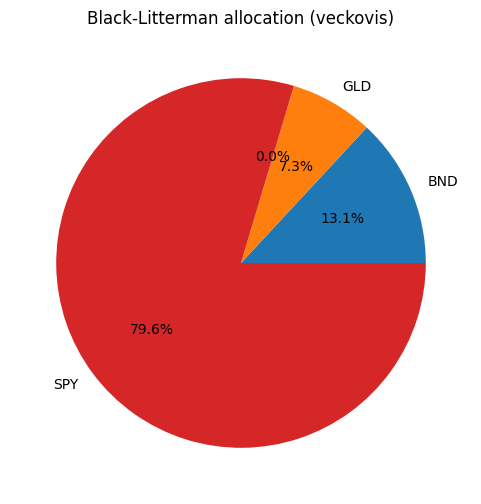

In [3]:
mcaps = {
    "SPY": 481_714_784_600,
    "BND": 122_936_437_056,
    "GLD":  77_500_318_000,
    "HODL.PA": 1_200_295_500,
}
cov   = risk_models.CovarianceShrinkage(closing_prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(closing_prices["SPY"])
pi    = black_litterman.market_implied_prior_returns(mcaps, delta, cov)

bl = BlackLittermanModel(
    cov,
    pi=pi,
    absolute_views=viewdict,
    omega="idzorek",
    view_confidences=confidences,
    risk_aversion=delta,
)
ef = EfficientFrontier(bl.bl_returns(), bl.bl_cov())
ef.max_sharpe()
weights = ef.clean_weights()

print("Views:", viewdict)
print("Conf:", confidences)

print("\nOPTIMERAD PORTFÖLJ (weekly BL):")
for k, v in weights.items():
    print(f"  {k:7s}: {v*100:5.1f} %")

# (valfritt) visa fördelningen
pd.Series(weights).plot.pie(figsize=(6,6), autopct='%1.1f%%')
plt.ylabel("")
plt.title("Black-Litterman allocation (veckovis)")
plt.show()
